<img align="right" width="200" height="200" src="https://static.wikia.nocookie.net/lego/images/2/23/PPG_logo.png"> 

# <span style="color:#EF7C8E">Noon Perfume Model - Capstone Project - Building a content based filtering Model </span>
 


## <span style="color:#55BB99"> Group: Power Puff Girls</span>
### <span style="color:#726060"> Members: Wejdan Al-Ahmadi - Sara Aldubaie</span>
<hr style="border:2px solid gray"> </hr>

## * NOTE:* The models in this notebook were trained on a random 100 sampling of data points (100 records)

In [1]:
#pip install autocorrect==2.4.0

In [2]:
#pip install fuzzywuzzy

In [3]:
#pip install python-Levenshtein

In [4]:
#pip install recmetrics

In [5]:
#pip install funcsigs

In [6]:
#pip install recmetrics==0.0.12
# note i got an error while loading this library and the fix i found was you need to manually change the import 
# in the 'plot.py' file Instead of 'from sklearn.utils.fixes import signature' use 'from funcsigs import signature'

In [7]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import recmetrics

warnings.simplefilter(action='ignore', category=FutureWarning)

## Cos Sim model

In [8]:
# data import
noon_clean = pd.read_csv('./data/noon_clean_Model.csv')
# filling NA's with empty string
noon_clean=noon_clean.fillna('')

In [9]:
import random
for i in noon_clean.index:
    if (noon_clean.at[i, 'Scents/Notes']=="Floral"):
        noon_clean.at[i, 'Popularity'] = random.randrange(1650, 1800, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Woody"):
        noon_clean.at[i, 'Popularity'] = random.randrange(1550, 1700, 10)  
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Fresh"):
        noon_clean.at[i, 'Popularity'] = random.randrange(1450, 1600, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Oriental"):
        noon_clean.at[i, 'Popularity'] = random.randrange(1350, 1500, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Fruity"):
        noon_clean.at[i, 'Popularity'] = random.randrange(1250, 1400, 10) 
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Arabian"):
        noon_clean.at[i, 'Popularity'] = random.randrange(1150, 1300, 10) 
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Spicy"):
        noon_clean.at[i, 'Popularity'] = random.randrange(1050, 1200, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Citrus"):
        noon_clean.at[i, 'Popularity'] = random.randrange(950, 1100, 10) 
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Aromatic"):
        noon_clean.at[i, 'Popularity'] = random.randrange(850, 1000, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Vanilla"):
        noon_clean.at[i, 'Popularity'] = random.randrange(750, 900, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Musk"):
        noon_clean.at[i, 'Popularity'] = random.randrange(650, 800, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Sweet"):
        noon_clean.at[i, 'Popularity'] = random.randrange(550, 700, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Jasmine"):
        noon_clean.at[i, 'Popularity'] = random.randrange(450, 600, 10)     
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Sandalwood"):
        noon_clean.at[i, 'Popularity'] = random.randrange(350, 500, 10)
        
    elif(noon_clean.at[i, 'Scents/Notes']=="Clean"):
        noon_clean.at[i, 'Popularity'] = random.randrange(250, 400, 10)   
noon_clean.Popularity=noon_clean.Popularity.astype(str)


In [10]:
# get copy to work with cos sim and binary matrix 
noon_bin = noon_clean.copy()
# applying the split by ',' to the base note column
noon_bin['Base Note']=noon_bin['Base Note'].apply(lambda x: x.split(","))
noon_bin['Heart/Middle Note']=noon_bin['Heart/Middle Note'].apply(lambda x: x.split(","))
noon_bin['Top Note']=noon_bin['Top Note'].apply(lambda x: x.split(","))
#noon_bin.head()

In [11]:
from collections import Counter

# Top note freq counter
top_note_counts = Counter(tn for top_note in noon_bin['Top Note'] for tn in top_note)
print(f"There are {len(top_note_counts)} Top note labels.")

# middle note freq counter
middle_note_counts = Counter(mn for middle_note in noon_bin['Heart/Middle Note'] for mn in middle_note)
print(f"There are {len(middle_note_counts)} Heart/Middle note labels.")


# base note freq counter
base_note_counts = Counter(bn for base_note in noon_bin['Base Note'] for bn in base_note)
print(f"There are {len(base_note_counts)} base note labels.")

# popularity freq counter
pop_counter=Counter(noon_bin[noon_bin['Popularity'].notnull()]['Popularity'])
print(f"There are {len(base_note_counts)} popularity labels.")

print("Example of base notes counter:",base_note_counts.most_common(5))

There are 1204 Top note labels.
There are 1750 Heart/Middle note labels.
There are 1394 base note labels.
Example of base notes counter: [('musk', 1635), ('vanilla', 1299), ('amber', 1299), ('sandalwood', 1253), ('patchouli', 1212)]


In [12]:
from itertools import dropwhile
# drop any note that has not been repeated at least once, because for our recommendation system to work we need at least 2
# frequencies of a note to make the recommendation

# top notes
for key, count in dropwhile(lambda key_count: key_count[1] >= 2, top_note_counts.most_common()):
    del top_note_counts[key]

# middle notes
for key, count in dropwhile(lambda key_count: key_count[1] >= 2, middle_note_counts.most_common()):
    del middle_note_counts[key]
    
# base notes    
for key, count in dropwhile(lambda key_count: key_count[1] >= 2, base_note_counts.most_common()):
    del base_note_counts[key]
    
print(f"There are {len(top_note_counts)} Top note labels.")
print(f"There are {len(middle_note_counts)} Heart/Middle note labels.")
print(f"There are {len(base_note_counts)} base note labels.")

There are 451 Top note labels.
There are 651 Heart/Middle note labels.
There are 521 base note labels.


In [13]:
# this is to handle the null values that were replaced by an empty string
del top_note_counts['']
del middle_note_counts['']
del base_note_counts['']

In [14]:
# Top 5 most common top notes
print("The 5 most common top notes: \n", top_note_counts.most_common(5))
print('--'*50)
# Top 5 most common middle notes
print("The 5 most common middle notes: \n", middle_note_counts.most_common(5))
print('--'*50)
# Top 5 most common base notes
print("The 5 most common base notes: \n", base_note_counts.most_common(5))

The 5 most common top notes: 
 [('bergamot', 684), ('lemon', 264), ('pinkpepper', 161), ('grapefruit', 157), ('mandarinorange', 156)]
----------------------------------------------------------------------------------------------------
The 5 most common middle notes: 
 [('jasmine', 1256), ('rose', 1053), ('lily', 385), ('orangeblossom', 373), ('patchouli', 350)]
----------------------------------------------------------------------------------------------------
The 5 most common base notes: 
 [('musk', 1635), ('vanilla', 1299), ('amber', 1299), ('sandalwood', 1253), ('patchouli', 1212)]


In [15]:
# we need to create a binary matrix for the selected features, where the rows represent each perfume and the columns 
# represent the features, 1 means this perfume has this note and 0 means it does not

#-------------------------------------- TOP NOTE--------------------------------------#

top_notes = list(top_note_counts.keys())

# create the binary matrix for top notes
for tn in top_notes:
    noon_bin[tn] = noon_bin['Top Note'].transform(lambda x: int(tn in x))
    
#-------------------------------------- MIDDLE NOTE-----------------------------------#

middle_notes = list(middle_note_counts.keys())

# create the binary matrix for middle notes
for mn in middle_notes:
    noon_bin[mn] = noon_bin['Heart/Middle Note'].transform(lambda x: int(mn in x))
#-------------------------------------- BASE NOTE-------------------------------------#

base_notes = list(base_note_counts.keys())

# create the binary matrix for base notes
for bn in base_notes:
    noon_bin[bn] = noon_bin['Base Note'].transform(lambda x: int(bn in x))
    
    
popularity_keys=list(pop_counter.keys())
# create the binary matrix for base notes
for pop in popularity_keys:
    noon_bin[pop] = noon_bin['Popularity'].transform(lambda x: int(pop in x))


#--------------------------------------POPULARITY-------------------------------------#
popularity_keys=list(pop_counter.keys())

# create the binary matrix for popularity
for pop in popularity_keys:
    noon_bin[pop] = noon_bin['Popularity'].transform(lambda x: int(pop in x))


print('Top notes Binary matrix \nrows: ', noon_bin[top_notes].shape[0], '\ncolumns: ',noon_bin[top_notes].shape[1])
print('--'*50)
print('Middle notes Binary matrix \nrows: ', noon_bin[middle_notes].shape[0], '\ncolumns: ',noon_bin[middle_notes].shape[1])
print('--'*50)
print('Base notes Binary matrix \nrows: ', noon_bin[base_notes].shape[0], '\ncolumns: ',noon_bin[base_notes].shape[1])
print('--'*50)
print('Popularity Binary matrix \nrows: ', noon_bin[popularity_keys].shape[0], '\ncolumns: ',noon_bin[popularity_keys].shape[1])

Top notes Binary matrix 
rows:  5192 
columns:  450
----------------------------------------------------------------------------------------------------
Middle notes Binary matrix 
rows:  5192 
columns:  650
----------------------------------------------------------------------------------------------------
Base notes Binary matrix 
rows:  5192 
columns:  520
----------------------------------------------------------------------------------------------------
Popularity Binary matrix 
rows:  5192 
columns:  144


In [16]:
# save the binary matrix in a new variable

# top note
perfume_features_TN = noon_bin[top_notes]

# middle note
perfume_features_MN = noon_bin[middle_notes]

# base note
perfume_features_BN = noon_bin[base_notes]

# popularity
popularity_features_BN = noon_bin[popularity_keys]

In [17]:
# concat all the notes to get all features
perfume_features_pop = pd.concat([perfume_features_TN,perfume_features_MN,perfume_features_BN,popularity_features_BN], axis=1)
perfume_features=pd.concat([perfume_features_TN,perfume_features_MN,perfume_features_BN], axis=1)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# create a cosine similarity matrix using the binary matrix
# all 
cosine_sim_All = cosine_similarity(perfume_features, perfume_features)
print(f"Dimensions of our perfume features (All Notes) cosine similarity matrix: {cosine_sim_All.shape}")

# All note+popularity
cosine_sim_All_pop = cosine_similarity(perfume_features_pop, perfume_features_pop)
print(f"Dimensions of our perfume features (All Notes+Pop) cosine similarity matrix: {cosine_sim_All_pop.shape}")

# top note
cosine_sim_TN = cosine_similarity(perfume_features_TN, perfume_features_TN)
print(f"Dimensions of our perfume features (Top Notes) cosine similarity matrix: {cosine_sim_TN.shape}")

# middle note
cosine_sim_MN = cosine_similarity(perfume_features_MN, perfume_features_MN)
print(f"Dimensions of our perfume features (Middle Notes) cosine similarity matrix: {cosine_sim_MN.shape}")

# base note
cosine_sim_BN = cosine_similarity(perfume_features_BN, perfume_features_BN)
print(f"Dimensions of our perfume features (Base Notes) cosine similarity matrix: {cosine_sim_BN.shape}")

Dimensions of our perfume features (All Notes) cosine similarity matrix: (5192, 5192)
Dimensions of our perfume features (All Notes+Pop) cosine similarity matrix: (5192, 5192)
Dimensions of our perfume features (Top Notes) cosine similarity matrix: (5192, 5192)
Dimensions of our perfume features (Middle Notes) cosine similarity matrix: (5192, 5192)
Dimensions of our perfume features (Base Notes) cosine similarity matrix: (5192, 5192)


In [19]:
from fuzzywuzzy import process

# using the fuzzy wuzzy package, we can get the exact name of the perfume even if its misspelled 
def perfume_finder(name):
    all_names = noon_clean['name'].tolist()
    closest_match = process.extractOne(name,all_names)
    return closest_match[0]

In [20]:
# we need to get the index of the 'Azurl' perfume in the cosine sim matrix to find recommendations for it

# this is a dictionary where the keys are perfume names and the values are perfume indices
perfume_idx = dict(zip(noon_bin['name'], list(noon_bin.index)))

In [21]:
# this function takes the name of the perfume and how many recommendations and returns them both
def get_content_based_recommendations(name_string, note_type, rec_type='match',depart_filter='off' ):
    name = perfume_finder(name_string)
    idx = perfume_idx[name]
    rec_list=[]
    better_rec=[]  
    selected_depart=noon_clean[noon_clean['name']==name]['Department'].values[0]
    n_recommendations=30

    # for base note 
    if note_type == 'base':
        
        sim_scores = list(enumerate(cosine_sim_BN[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:(n_recommendations+1)]
        similar_perfumes = [i[0] for i in sim_scores]      
        list_names=list(noon_bin['name'].iloc[similar_perfumes])
        for i in list_names: 
            rec_depart=noon_clean[noon_clean['name']==i]['Department'].values[0]
            if(rec_depart==selected_depart):
                better_rec.append(i)
                
        rec_list=list(noon_bin['name'].iloc[similar_perfumes])

    # for top note
    elif note_type == 'top': 
        
        sim_scores_t = list(enumerate(cosine_sim_TN[idx]))
        sim_scores_t = sorted(sim_scores_t, key=lambda x: x[1], reverse=True)
        sim_scores_t = sim_scores_t[1:(n_recommendations+1)]
        similar_perfumes_t = [i[0] for i in sim_scores_t]       
        list_names=list(noon_bin['name'].iloc[similar_perfumes_t])
        for i in list_names: 
            rec_depart=noon_clean[noon_clean['name']==i]['Department'].values[0]
            if(rec_depart==selected_depart):
                better_rec.append(i)
        
        rec_list=list(noon_bin['name'].iloc[similar_perfumes_t])
        
    # for middle note    
    elif note_type == 'middle': 
        
        sim_scores_m = list(enumerate(cosine_sim_MN[idx]))
        sim_scores_m = sorted(sim_scores_m, key=lambda x: x[1], reverse=True)
        sim_scores_m = sim_scores_m[1:(n_recommendations+1)]
        similar_perfumes_m = [i[0] for i in sim_scores_m]
        list_names=list(noon_bin['name'].iloc[similar_perfumes_m])
        for i in list_names: 
            rec_depart=noon_clean[noon_clean['name']==i]['Department'].values[0]
            if(rec_depart==selected_depart):
                better_rec.append(i)
        rec_list=list(noon_bin['name'].iloc[similar_perfumes_m])
        
    # for all note    
    elif note_type == 'all_pop': 
        
        sim_scores_a = list(enumerate(cosine_sim_All_pop[idx]))
        sim_scores_a = sorted(sim_scores_a, key=lambda x: x[1], reverse=True)
        sim_scores_a = sim_scores_a[1:(n_recommendations+1)]
        similar_perfumes_a = [i[0] for i in sim_scores_a]
        list_names=list(noon_bin['name'].iloc[similar_perfumes_a])
        for i in list_names: 
            rec_depart=noon_clean[noon_clean['name']==i]['Department'].values[0]
            if(rec_depart==selected_depart):
                better_rec.append(i)
        rec_list=list(noon_bin['name'].iloc[similar_perfumes_a])
        
    # for all note    
    elif note_type == 'all': 
        
        sim_scores_a2 = list(enumerate(cosine_sim_All[idx]))
        sim_scores_a2 = sorted(sim_scores_a2, key=lambda x: x[1], reverse=True)
        sim_scores_a2 = sim_scores_a2[1:(n_recommendations+1)]
        similar_perfumes_a2 = [i[0] for i in sim_scores_a2]
        list_names=list(noon_bin['name'].iloc[similar_perfumes_a2])
        for i in list_names: 
            rec_depart=noon_clean[noon_clean['name']==i]['Department'].values[0]
            if(rec_depart==selected_depart):
                better_rec.append(i)        
        rec_list=list(noon_bin['name'].iloc[similar_perfumes_a2])
        
    if(depart_filter=='on'):
        if(rec_type=='match'):
            better_rec=better_rec[0]
        elif(rec_type=='complement'):
            better_rec=better_rec[0:3]
    elif(depart_filter=='off'):
        if(rec_type=='match'):
            better_rec=rec_list[0]
        elif(rec_type=='complement'):
            better_rec=rec_list[0:3]
            
    return better_rec

## TF IDF cos sim model
It is a content based recommender system that uses tf-idf and cosine similarity for N Most SImilar Items from a dataset

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [23]:
# get copy to work with cos sim and TFIDF matrix
noon_tfidf=noon_clean.copy()

In [24]:
# get TF IDF of the base note column
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(noon_tfidf['Base Note'])

In [25]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
#cosine_similarities

In [26]:
# this function takes the name of the perfume and how many recommendations and returns them both
def get_TFIDF_recommendations(name_string, n_recommendations=10):
    name = perfume_finder(name_string)
    idx = perfume_idx[name]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_perfumes = [i[0] for i in sim_scores]
    rec_list=list(noon_tfidf['name'].iloc[similar_perfumes])
    return rec_list

## Evaluation using coverage

In [27]:
test = noon_clean.copy()
test=test[['name','Department']]

In [28]:
# get 100 random samples
test=test.iloc[0:99]

In [29]:
#make recommendations for all perfumes in the test data

ran_recs = []
for name in test.name:
    random_predictions = noon_clean.name.sample(3).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs

In [30]:
#make recommendations for all perfumes in the test data

cos_ALL_recs = []
for name in test.name:
    cos_ALL_predictions = get_content_based_recommendations(name,'all','complement','off')
    cos_ALL_recs.append(cos_ALL_predictions)
        
test['cos_ALL_predictions'] = cos_ALL_recs

In [31]:
#make recommendations for all perfumes in the test data

cos_ALL_POP_recs = []
for name in test.name:
    cos_ALL_POP_predictions = get_content_based_recommendations(name,'all_pop','complement','off') 
    cos_ALL_POP_recs.append(cos_ALL_POP_predictions)
        
test['cos_ALL_POP_predictions'] = cos_ALL_POP_recs

In [32]:
#make recommendations for all perfumes in the test data

cos_BN_recs = []
for name in test.name:
    cos_BN_predictions = get_content_based_recommendations(name,'base','complement','off') 
    cos_BN_recs.append(cos_BN_predictions)
        
test['cos_BN_predictions'] = cos_BN_recs

In [33]:
#make recommendations for all perfumes in the test data

cos_MN_recs = []
for name in test.name:
    cos_MN_predictions = get_content_based_recommendations(name,'middle','complement','off')
    cos_MN_recs.append(cos_MN_predictions)
        
test['cos_MN_predictions'] = cos_MN_recs

In [34]:
#make recommendations for all perfumes in the test data

cos_TN_recs = []
for name in test.name:
    cos_TN_predictions = get_content_based_recommendations(name,'top','complement','off') 
    cos_TN_recs.append(cos_TN_predictions)
        
test['cos_TN_predictions'] = cos_TN_recs

In [35]:
#make recommendations for all perfumes in the test data

tfidf_recs = []
for name in test.name:
    tfidf_predictions = get_TFIDF_recommendations(name,3)
    tfidf_recs.append(tfidf_predictions)
        
test['tfidf_sim_predictions'] = tfidf_recs

In [36]:
# I divided by 3 because each rec system will give 3 recommendations per record
catalog = test.name.unique().tolist()
random_coverage = (recmetrics.coverage(ran_recs, catalog))/3
tfidf_coverage = (recmetrics.coverage(tfidf_recs, catalog))/3
cos_BN_coverage = (recmetrics.coverage(cos_BN_recs, catalog))/3
cos_ALL_POP_coverage = (recmetrics.coverage(cos_ALL_POP_recs, catalog))/3
cos_TN_coverage = (recmetrics.coverage(cos_TN_recs, catalog))/3
cos_MN_coverage = (recmetrics.coverage(cos_MN_recs, catalog))/3
cos_ALL_coverage = (recmetrics.coverage(cos_ALL_recs, catalog))/3


In [37]:
print(f"Coverage % of random reccomends for 5192 records: {round(random_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using TFIDF factorization and base notes for 100 records: {round(tfidf_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using binary matrix and base notes for 100 records: {round(cos_BN_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using binary matrix and all+Popularity  notes for 100 records: {round(cos_ALL_POP_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using binary matrix and all notes for 100 records: {round(cos_ALL_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using binary matrix and middle notes for 100 records: {round(cos_MN_coverage,2)}%\n")
print(f"Coverage % of cosine sim reccomends using binary matrix and top notes for 100 records: {round(cos_TN_coverage,2)}%\n")


Coverage % of random reccomends for 5192 records: 113.73%

Coverage % of cosine sim reccomends using TFIDF factorization and base notes for 100 records: 80.78%

Coverage % of cosine sim reccomends using binary matrix and base notes for 100 records: 77.65%

Coverage % of cosine sim reccomends using binary matrix and all+Popularity  notes for 100 records: 85.1%

Coverage % of cosine sim reccomends using binary matrix and all notes for 100 records: 79.22%

Coverage % of cosine sim reccomends using binary matrix and middle notes for 100 records: 78.04%

Coverage % of cosine sim reccomends using binary matrix and top notes for 100 records: 78.43%



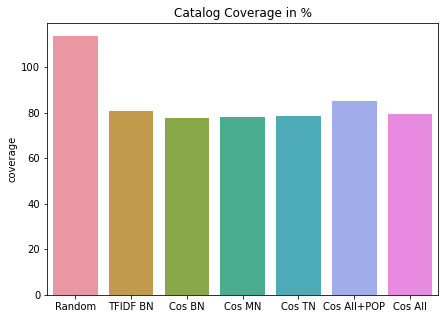

In [38]:
# plot of prediction coverage
coverage_scores = [random_coverage, tfidf_coverage,cos_BN_coverage,cos_MN_coverage,cos_TN_coverage,cos_ALL_POP_coverage,cos_ALL_coverage]
model_names = ['Random', 'TFIDF BN','Cos BN','Cos MN','Cos TN',"Cos All+POP",'Cos All']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)